In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_predict,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,silhouette_score

In [2]:
df=pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.drop(['CustomerID'], axis=1, inplace=True)

In [4]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [5]:
df.isna().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
encoder=LabelEncoder()
df['Genre'] = encoder.fit_transform(df['Genre'])

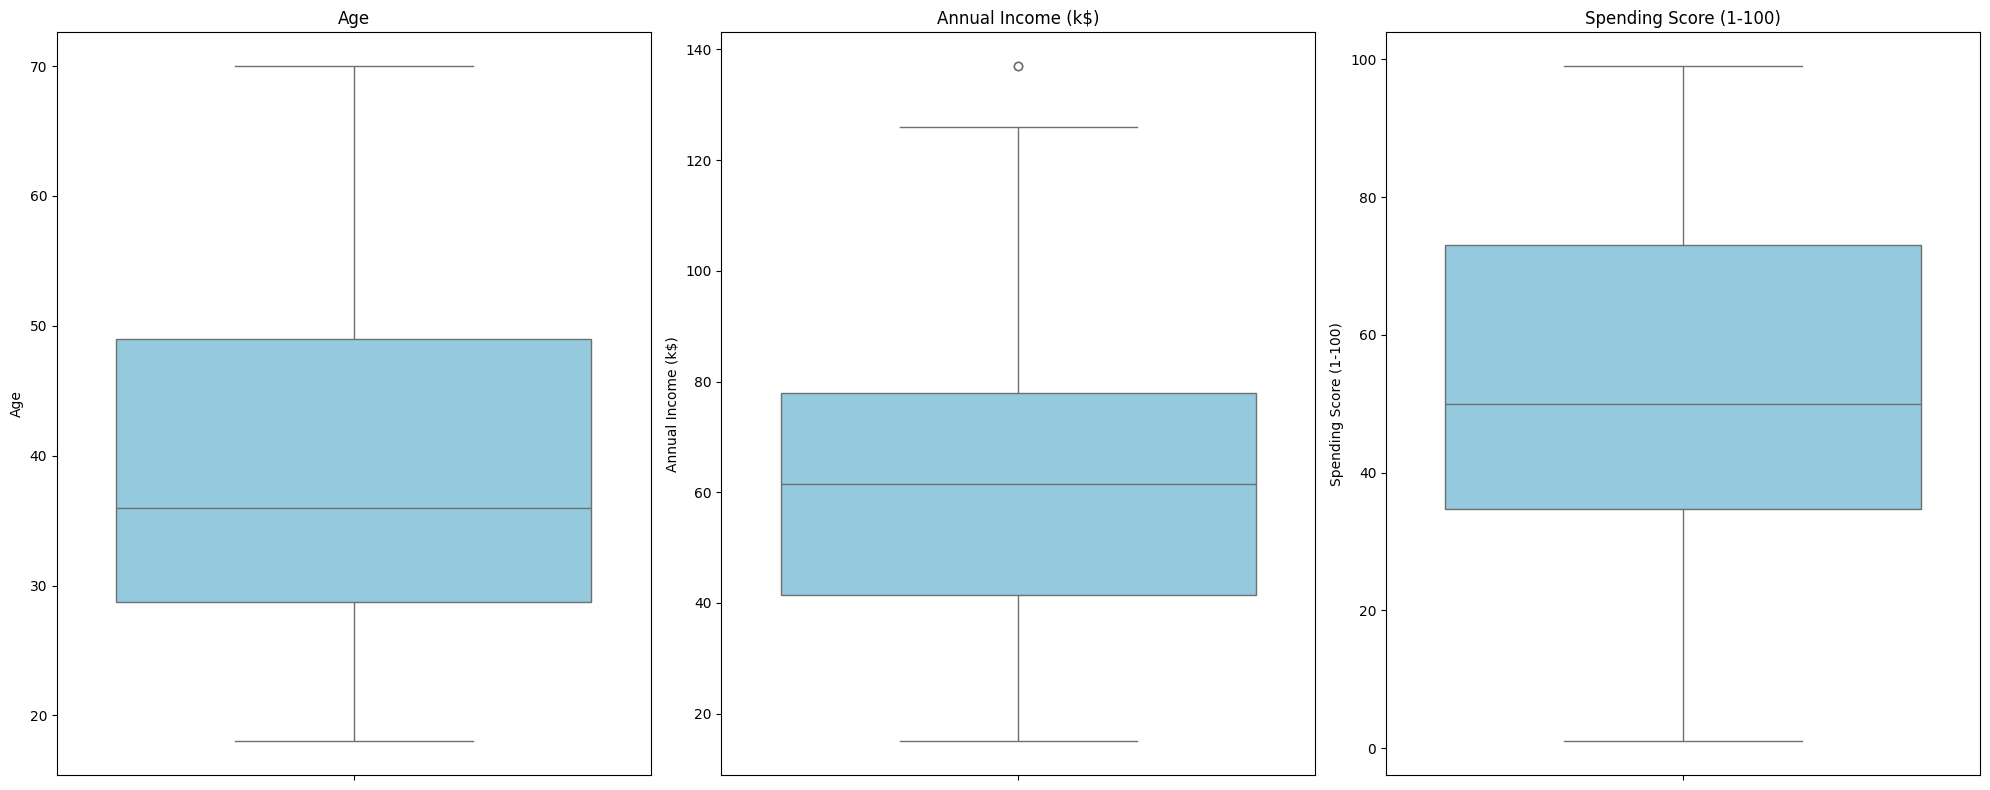

In [8]:
dd=df.drop(['Genre'], axis=1)
plt.figure(figsize=(20, 8))
for i, column in enumerate(dd.columns, 1):
    plt.subplot(1, len(dd.columns), i)
    sns.boxplot(y=dd[column], color='skyblue')
    plt.title(column)
    plt.tight_layout()

plt.show()

In [9]:
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaled_array = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)

In [ ]:
def remove_outliers(df_scaled):
    upper_bound = {}
    lower_bound = {}

    for col in df_scaled.columns:
        q1 = df_scaled[col].quantile(0.25)
        q3 = df_scaled[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound[col] = q3 + 1.5 * iqr
        lower_bound[col] = q1 - 1.5 * iqr

    df_cleaned = df_scaled.copy()
    for col in df_scaled.columns:
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound[col]) & (df_cleaned[col] <= upper_bound[col])]
    return df_cleaned

df_scaled = remove_outliers(df_scaled)

In [12]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


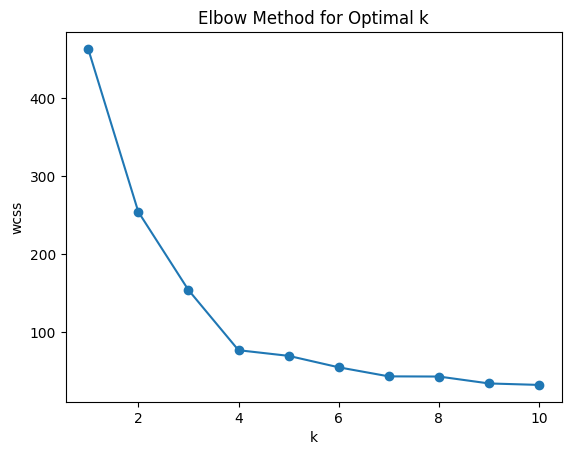

In [13]:
pca = PCA(n_components=2, random_state=42)
x = pca.fit_transform(df_scaled)
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    WCSS.append(kmeans.inertia_)

plt.plot(range(1,11), WCSS, marker='o')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('Elbow Method for Optimal k')
plt.show()

In [14]:
model = KMeans(n_clusters=4, random_state=42)
labels = model.fit_predict(x)
df_scaled['Cluster'] = labels

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

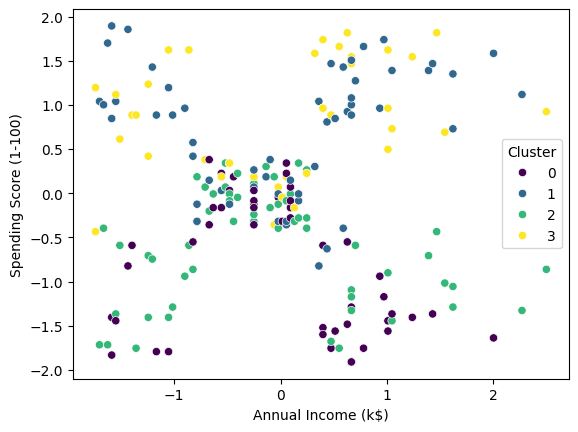

In [15]:
sns.scatterplot(data=df_scaled, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis')

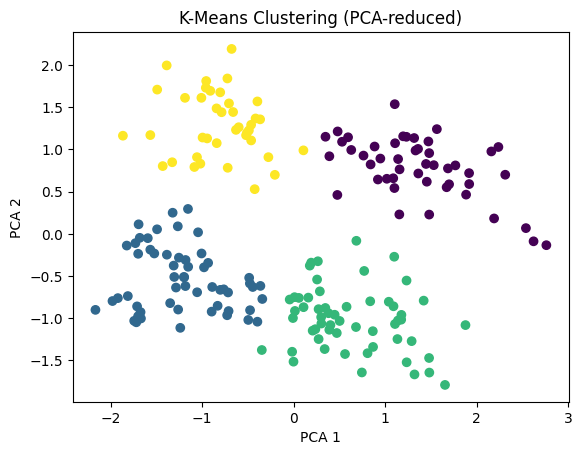

In [16]:
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means Clustering (PCA-reduced)')
plt.show()

In [17]:
score = silhouette_score(x, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.5503428307629536


In [18]:
temp_df = scaler.inverse_transform(df_scaled.drop(['Cluster'], axis=1))
temp_df = pd.DataFrame(temp_df, columns=df_scaled.drop(['Cluster'], axis=1).columns)
temp_df['Cluster'] = df_scaled['Cluster']
cluster_stats = temp_df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].agg(['mean', 'std', 'min', 'max', 'count'])
print(cluster_stats)


               Age                              Annual Income (k$)             \
              mean        std   min   max count               mean        std   
Cluster                                                                         
0        49.808511  13.940305  19.0  70.0    47          60.829787  22.353211   
1        28.392857   5.532314  18.0  40.0    56          60.428571  26.064854   
2        47.803571  10.011665  20.0  68.0    56          58.071429  26.140778   
3        28.205128   7.060563  18.0  40.0    39          60.076923  26.801792   

                           Spending Score (1-100)                               
          min    max count                   mean        std   min   max count  
Cluster                                                                         
0        19.0  113.0    47              29.446809  19.402833   1.0  60.0    47  
1        16.0  120.0    56              68.178571  18.502194  29.0  99.0    56  
2        16.0  126.0    56 

In [19]:
cluster_labels = {
    0: 'Frugal Elders',
    1: 'Impulsive Youth',
    2: 'Conservative Adults',
    3: 'Enthusiastic Shoppers'
}

df_scaled['Cluster'] =df_scaled['Cluster'].map(cluster_labels)

In [28]:
df_scaled.head()
d=pd.DataFrame(scaler.inverse_transform(df_scaled.drop(['Cluster'], axis=1)), columns=df_scaled.drop(['Cluster'], axis=1).columns)
d['Cluster']=df_scaled['Cluster']
d.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1.0,19.0,15.0,39.0,Enthusiastic Shoppers
1,1.0,21.0,15.0,81.0,Enthusiastic Shoppers
2,0.0,20.0,16.0,6.0,Conservative Adults
3,0.0,23.0,16.0,77.0,Impulsive Youth
4,0.0,31.0,17.0,40.0,Conservative Adults


In [ ]:
features = df_scaled.drop(['Cluster'], axis=1)
target = df_scaled['Cluster']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


knn_pipeline = Pipeline([
    ('scaled_array', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5)
knn_grid.fit(x_train, y_train)

print("\n KNN Best Params:", knn_grid.best_params_)
print(" KNN Test Accuracy:", knn_grid.score(x_test, y_test))
print(" KNN CV Mean Score:", knn_grid.best_score_)

nb_pipeline = Pipeline([
    ('scaled_array', StandardScaler()),
    ('nb', GaussianNB())
])
nb_params = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]
}
nb_grid = GridSearchCV(nb_pipeline, nb_params, cv=5)
nb_grid.fit(x_train, y_train)

print("\n Naive Bayes Best Params:", nb_grid.best_params_)
print(" Naive Bayes Test Accuracy:", nb_grid.score(x_test, y_test))
print(" Naive Bayes CV Mean Score:", nb_grid.best_score_)

dt_pipeline = Pipeline([
    ('scaled_array', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])
dt_params = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [3, 5, 10, None],
    'dt__min_samples_split': [2, 5, 10]
}
dt_grid = GridSearchCV(dt_pipeline, dt_params, cv=5)
dt_grid.fit(x_train, y_train)

print("\n Decision Tree Best Params:", dt_grid.best_params_)
print(" Decision Tree Test Accuracy:", dt_grid.score(x_test, y_test))
print(" Decision Tree CV Mean Score:", dt_grid.best_score_)


 KNN Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
 KNN Test Accuracy: 1.0
 KNN CV Mean Score: 0.9872983870967742

 Naive Bayes Best Params: {'nb__var_smoothing': 1e-09}
 Naive Bayes Test Accuracy: 1.0
 Naive Bayes CV Mean Score: 0.98125

 Decision Tree Best Params: {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_split': 2}
 Decision Tree Test Accuracy: 0.9
 Decision Tree CV Mean Score: 0.9622983870967742


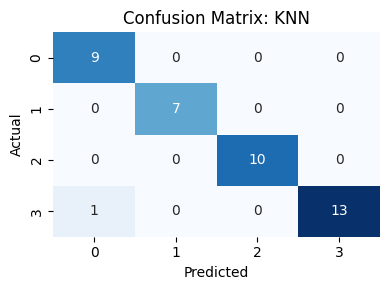

Classification Report: KNN
                       precision    recall  f1-score   support

  Conservative Adults       0.90      1.00      0.95         9
Enthusiastic Shoppers       1.00      1.00      1.00         7
        Frugal Elders       1.00      1.00      1.00        10
      Impulsive Youth       1.00      0.93      0.96        14

             accuracy                           0.97        40
            macro avg       0.97      0.98      0.98        40
         weighted avg       0.98      0.97      0.98        40



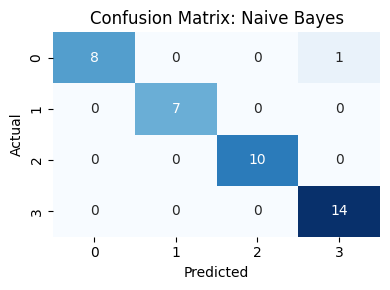

Classification Report: Naive Bayes
                       precision    recall  f1-score   support

  Conservative Adults       1.00      0.89      0.94         9
Enthusiastic Shoppers       1.00      1.00      1.00         7
        Frugal Elders       1.00      1.00      1.00        10
      Impulsive Youth       0.93      1.00      0.97        14

             accuracy                           0.97        40
            macro avg       0.98      0.97      0.98        40
         weighted avg       0.98      0.97      0.97        40



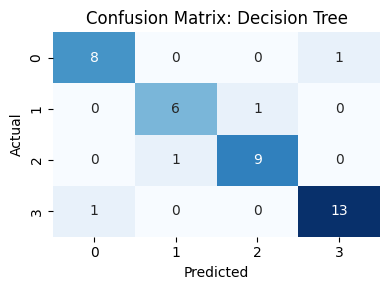

Classification Report: Decision Tree
                       precision    recall  f1-score   support

  Conservative Adults       0.89      0.89      0.89         9
Enthusiastic Shoppers       0.86      0.86      0.86         7
        Frugal Elders       0.90      0.90      0.90        10
      Impulsive Youth       0.93      0.93      0.93        14

             accuracy                           0.90        40
            macro avg       0.89      0.89      0.89        40
         weighted avg       0.90      0.90      0.90        40



In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

y_pred_knn = cross_val_predict(knn_pipeline, x_test, y_test, cv=3)
y_pred_nb = cross_val_predict(nb_pipeline, x_test, y_test, cv=3)
y_pred_dt = cross_val_predict(dt_pipeline, x_test, y_test, cv=3)

plot_confusion_matrix(y_test, y_pred_knn, "Confusion Matrix: KNN")
print("Classification Report: KNN")
print(classification_report(y_test, y_pred_knn))

plot_confusion_matrix(y_test, y_pred_nb, "Confusion Matrix: Naive Bayes")
print("Classification Report: Naive Bayes")
print(classification_report(y_test, y_pred_nb))

plot_confusion_matrix(y_test, y_pred_dt, "Confusion Matrix: Decision Tree")
print("Classification Report: Decision Tree")
print(classification_report(y_test, y_pred_dt))

##

In [23]:
joblib.dump(knn_grid.best_estimator_, "Deployment/knn_model.pkl")
joblib.dump(nb_grid.best_estimator_, "Deployment/nb_model.pkl")
joblib.dump(dt_grid.best_estimator_, "Deployment/dt_model.pkl")
joblib.dump(scaler, "Deployment/scaler.pkl")

['Deployment/scaler.pkl']

In [ ]:
sample = [[0, 22, 17, 76]] 
prediction = nb_grid.best_estimator_.predict(sample)
print(prediction)

['Impulsive Youth']


c:\Users\Hashir\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
